In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/superheroes/"


In [4]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [5]:
ls {PATH}

CAX_Superhero_Test/                       Sample_Submission_Values.csv
CAX_Superhero_Test.zip                    Superhero_3375_SampleSubmission.csv
CAX_Superhero_Train/                      Superhero_Submission_Format.csv
CAX_Superhero_Train.zip                   tmp/
CrowdANALYTIX-Best-Practices-2018-v1.pdf  train/
__MACOSX/                                 valid/
models/


In [6]:
pathtrain = PATH+'train/'
pathvalid = PATH + 'valid/'
!ls {pathtrain}

Ant-Man  Avengers  Black_Panther    Catwoman	 Hulk	   Spiderman
Aquaman  Batman    Captain_America  Ghost_Rider  Iron_Man  Superman


## preprocessing

In [31]:
subd = [sub[22:] for sub in glob(pathtrain + '*/')]
len(subd), subd

(12,
 ['/Ghost Rider/',
  '/Spiderman/',
  '/Iron Man/',
  '/Batman/',
  '/Aquaman/',
  '/Ant-Man/',
  '/Superman/',
  '/Black Panther/',
  '/Catwoman/',
  '/Captain America/',
  '/Hulk/',
  '/Avengers/'])

In [37]:
for filename in os.listdir(pathtrain):
    print(filename, type(filename))

Ghost Rider <class 'str'>
Spiderman <class 'str'>
Iron Man <class 'str'>
Batman <class 'str'>
Aquaman <class 'str'>
Ant-Man <class 'str'>
Superman <class 'str'>
Black Panther <class 'str'>
Catwoman <class 'str'>
Captain America <class 'str'>
.DS_Store <class 'str'>
Hulk <class 'str'>
Avengers <class 'str'>


In [44]:
# change folder name to remove spaces
for folder in os.listdir(pathtrain):
    if ' ' in folder:
        newname = folder.replace(' ','_')
        os.rename(os.path.join(pathtrain, folder),
                  os.path.join(pathtrain, newname))

In [48]:
for folder in os.listdir(pathtrain):
    os.mkdir(pathvalid+folder)

!ls {pathvalid}

Ant-Man  Avengers  Black_Panther    Catwoman	 Hulk	   Spiderman
Aquaman  Batman    Captain_America  Ghost_Rider  Iron_Man  Superman


In [70]:
for folder in glob(pathtrain + '*/'):
    print(folder[23:])
    fullset = glob(folder + '*.*')
    n = len(fullset)
    valset = get_cv_idxs(n)
    for v in valset:
        !mv {fullset[v]} {pathvalid}{folder[23:]}

Iron_Man/
Spiderman/
Batman/
Aquaman/
Ant-Man/
Superman/
Catwoman/
Captain_America/
Hulk/
Black_Panther/
Avengers/
Ghost_Rider/


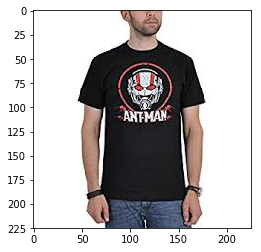

In [78]:
files = !ls {pathvalid}/Ant-Man | head
img = plt.imread(f'{pathvalid}/Ant-Man/{files[0]}')
plt.imshow(img)

In [79]:
img.shape

(225, 225, 3)

## check size

In [7]:
arch = resnext50
sz = 200
bs = 64
arch = resnext50
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch,sz))
#learn = ConvLearner.pretrained(arch, data, precompute=True)
#learn.fit(0.01,3)

In [8]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [9]:
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

(array([   3.,   31., 4382.,  427.,   13.,    3.,   14.,   13.,    2.,    2.]),
 array([ 73. , 119.7, 166.4, 213.1, 259.8, 306.5, 353.2, 399.9, 446.6, 493.3, 540. ]),
 <a list of 10 Patch objects>)

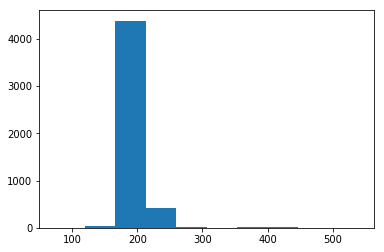

In [10]:
plt.hist(row_sz)

(array([   2.,    9.,   10.,   21., 4297.,  305.,   68.,  139.,    5.,    3.]),
 array([ 73. ,  98.7, 124.4, 150.1, 175.8, 201.5, 227.2, 252.9, 278.6, 304.3, 330. ]),
 <a list of 10 Patch objects>)

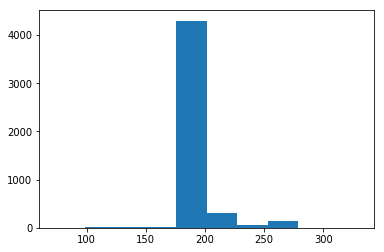

In [11]:
plt.hist(row_sz[row_sz<350])

(array([  15., 1528.,  334., 2978.,    5.,    0.,   13.,    0.,   16.,    1.]),
 array([120. , 160.2, 200.4, 240.6, 280.8, 321. , 361.2, 401.4, 441.6, 481.8, 522. ]),
 <a list of 10 Patch objects>)

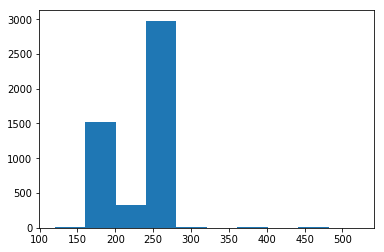

In [12]:
plt.hist(col_sz)

(array([   8.,    1.,    7.,  958.,  609.,  256.,   43., 2940.,   34.,    4.]),
 array([120., 138., 156., 174., 192., 210., 228., 246., 264., 282., 300.]),
 <a list of 10 Patch objects>)

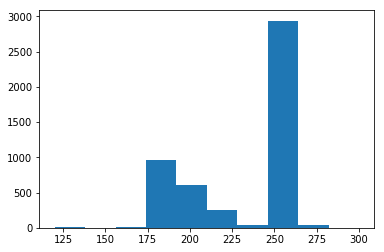

In [13]:
plt.hist(col_sz[col_sz<350])

## step 1

In [14]:
arch = resnext50
sz = 200
bs = 50

In [15]:
# create function to make it easy to vary img sz and bs for sota technique
# of increasing img sz and bs to prevent overfitting
def get_data(sz, bs):
    tfms = tfms_from_model(arch,sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340,'tmp')   

In [16]:
data = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

#learn.fit(0.01,3)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

## step 2

In [17]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 50%|█████     | 49/98 [00:00<00:00, 65.85it/s, loss=11.7]


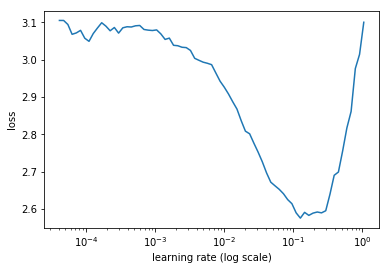

In [18]:
learn.sched.plot()

## step 3

In [19]:
learn.fit(0.02,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.816035   1.282004   0.584651  
    1      1.467031   1.200868   0.623425  



[1.2008684, 0.6234249418432062]

## step 4

In [20]:
learn.precompute=False
learn.fit(2e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.339081   1.141215   0.624609  
    1      1.27639    1.095728   0.638562  
    2      1.252654   1.095505   0.635222  



[1.0955049, 0.6352219879627228]

In [21]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.043878   0.843278   0.731882  
    1      0.700968   0.687653   0.763679  
    2      0.433859   0.649726   0.780042  
    3      0.376164   0.621784   0.812474  
    4      0.257568   0.596434   0.829725  
    5      0.171796   0.593066   0.836702  
    6      0.128092   0.575191   0.842156  



[0.5751914, 0.8421564427289095]

## repeat for sz = 255

In [22]:
learn.set_data(get_data(255,32))
learn.freeze()
#learn.precompute=True
#learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 127/153 [00:43<00:08,  2.94it/s, loss=0.617]

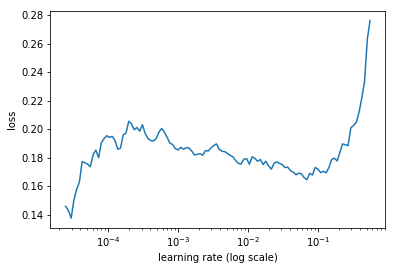

In [23]:
lrf2 = learn.lr_find()
learn.sched.plot()

In [24]:
learn.precompute=False
learn.fit(2e-3, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 10%|▉         | 15/153 [00:06<00:55,  2.50it/s, loss=0.173]


Exception in thread Thread-23:
Traceback (most recent call last):
  File "/home/jchoo/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/jchoo/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/jchoo/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy   
    0      0.18468    0.603278   0.823352  
    1      0.172467   0.588739   0.823352  
    2      0.162374   0.589238   0.827028  



[0.5892384, 0.8270279870313757]

In [25]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.274036   0.591634   0.815999  
    1      0.274701   0.637941   0.828926  
    2      0.140703   0.585318   0.823411  
    3      0.185203   0.6207     0.841793  
    4      0.132401   0.593835   0.845529  
    5      0.080742   0.558908   0.873043  
    6      0.062105   0.561432   0.862014  



[0.56143224, 0.8620137572288513]

In [26]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),axis=0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.8747697974217311, 0.5175626075522192)